In [2]:
import calendar
from io import StringIO
import json
import requests
from requests.auth import HTTPBasicAuth
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import xgboost as xgb

warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [ ]:
# Load in local variables not saved online for security
with open("../data/environmental/meteomatics/api_key.json", "r") as f:
    api_key = json.load(f)
USERNAME = api_key["username"]
PASSWORD = api_key["password"]

## Scalloped Hammerhead Shark - Presence/Absence Species Distribution Model

A model to predict the probability of a scalloped hammerhead shark being present based on environmental variables relating to a particular date, longitude and latitude.

This notebook does the following:
1. Loads in the scalloped hammerhead shark data downloaded from [GBIF](https://www.gbif.org/occurrence/download?taxon_key=2418789)
2. Defines the accessible area for the shark based on visualisation and general scientific understanding
3. Filters out any data that is outside of the area (e.g. on land)
4. Loads background data to tackle sampling bias and create more realistic absence points
5. Spatially thins out presence dataset to tackle sampling bias
6. Chooses appropriate absence points using monthly probability rasters based on the background dataset
7. Loads satellite data as the environmental variables (the input), at a daily cadence, and maps these to the presence/absence data
8. Compares distributions of the environmental variables between presence and absence - does anything stand out? Will this model work?
9. 5-fold spatial cross-validation using an XGBoost classifier and threshold optimisation via a small optimisation set
10. Evaluating model performance and consistency, then training a final model for full generalisability
11. Predicting based on data from 3rd October. This will influence where we should put the buoys today!

### 1. Raw Species Data

#### 1.1  Download and Process Presence Data
- Filtering:
  - High co-ordinate uncertainty or missing uncertainty
  - Missing latitude, longitude or dates - we need these to map to appropriate env. variables
  - Old data that will be missing satellite info

In [3]:
def load_raw_presence_data(filepath):
    df = pd.read_csv(filepath, sep='\t', on_bad_lines="skip")
    print(f"Species Counts: {df['species'].nunique()}")
    print(f"Initial number of rows: {df.shape[0]}")
    return df

def filter_basic_issues_from_dataset(df, coord_uncertainty_threshold=500, remove_uncertainty_nans=True):
    # Note - may want to be more lenient here depending on how dynamic the env variables are at short distances
    num_to_remove = ((df["coordinateUncertaintyInMeters"] >= coord_uncertainty_threshold)).sum()
    df = df[(df["coordinateUncertaintyInMeters"] < coord_uncertainty_threshold) |
            (df["coordinateUncertaintyInMeters"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on coordinate uncertainty, leaving {df.shape[0]} rows")
    
    if remove_uncertainty_nans:
        num_to_remove = (df["coordinateUncertaintyInMeters"].isna()).sum()
        df = df[~(df["coordinateUncertaintyInMeters"].isna())].reset_index(drop=True)
        print(f"Filtered out {num_to_remove} rows based on missing coordinate uncertainty, leaving {df.shape[0]} rows")
    
    # Remove rows with no lat/lon
    num_to_remove = (df["decimalLatitude"].isna() | df["decimalLongitude"].isna()).sum()
    df = df[~(df["decimalLatitude"].isna()) & ~(df["decimalLongitude"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on missing lat/lon, leaving {df.shape[0]} rows")
    df = df.rename(columns={"decimalLatitude": "latitude", "decimalLongitude": "longitude"})
    
    # Remove rows with invalid dates
    df["date"] = pd.to_datetime(df[["year", "month", "day"]], errors='coerce')
    num_to_remove = (df["date"].isna()).sum()
    df = df[~(df["date"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on invalid dates, leaving {df.shape[0]} rows")

    # Remove those too old to use recent satellite data
    num_to_remove = (df["date"] <= pd.Timestamp("2002-01-01")).sum()
    df = df[df["date"] > pd.Timestamp("2002-01-01")]
    print(f"Filtered out {num_to_remove} rows based on being too old, leaving {df.shape[0]} rows")
    return df

In [4]:
presence_df = load_raw_presence_data('../data/gbif/scalloped_hammerhead.csv')
presence_df = filter_basic_issues_from_dataset(
    presence_df, coord_uncertainty_threshold=500, remove_uncertainty_nans=False)
presence_df = presence_df[[
    "latitude",
    "longitude",
    "date"
]]
presence_gdf = gpd.GeoDataFrame(
    presence_df,
    geometry=gpd.points_from_xy(presence_df.longitude, presence_df.latitude),
    crs="EPSG:4326"  # Latitude, longitude, in degrees
)

Species Counts: 1
Initial number of rows: 28365
Filtered out 3001 rows based on coordinate uncertainty, leaving 25364 rows
Filtered out 1661 rows based on missing lat/lon, leaving 23703 rows
Filtered out 985 rows based on invalid dates, leaving 22718 rows
Filtered out 4642 rows based on being too old, leaving 18076 rows


#### 1.2 Initial Visualization
- Helps to define appropiate accessible area
- Load in coastline data as map overlay
- Longitude actually is the entire range (-180, 180)
- Latitude does have some limits
- Could be worth limiting our search initially to one continent, to start with. E.g. many points in North America.

In [5]:
coastline = gpd.read_file("../data/environmental/ne_10m_coastline/ne_10m_coastline.shp")

In [6]:
padding=2.0
max_lon = presence_gdf["longitude"].max() + padding
min_lon = presence_gdf["longitude"].min() - padding
max_lat = presence_gdf["latitude"].max() + padding
min_lat = presence_gdf["latitude"].min() - padding

# Correction - almost covered full range so it makes sense to keep it at full
max_lon = 180
min_lon = -180

(-38.14512, 44.8436)

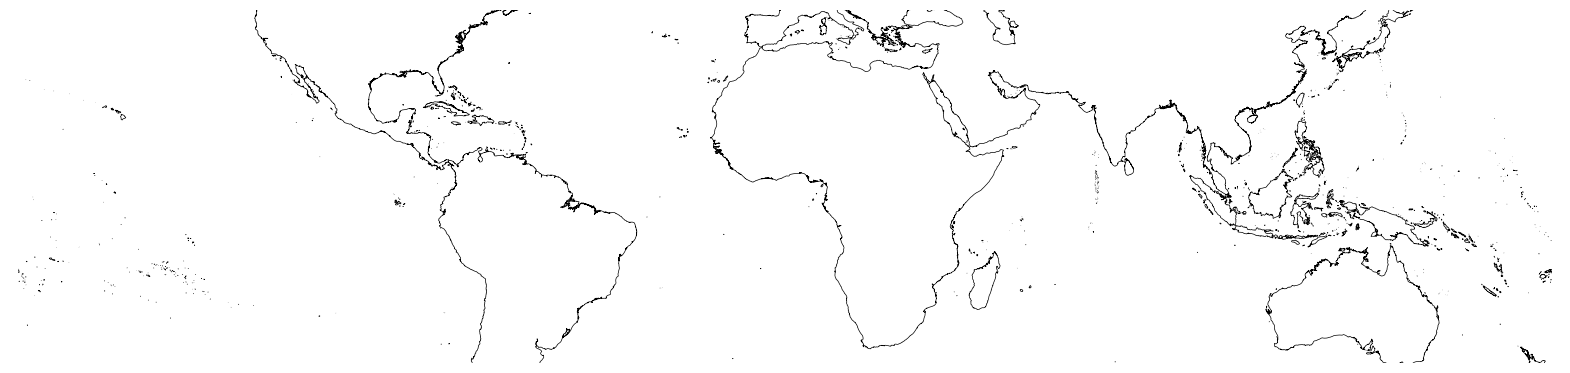

In [7]:
coastline = coastline.to_crs(epsg=4326)
coastline.plot(color="black", linewidth=0.5, figsize=(20,10), label="Coastline", alpha=1)
plt.axis("off")
plt.xlim(min_lon - 2, max_lon + 2)
plt.ylim(min_lat - 2, max_lat + 2)

In [8]:
def visualise_data_on_map(coastline, points_dfs=[], points_dfs_colors=[], points_dfs_labels=[], coastline_alpha=1, 
                          plot_bounding_box=True, limit_to_bounding_box=False, accessible_area=None, show_plot=True):
    coastline = coastline.to_crs(epsg=4326)
    coastline.plot(color="black", linewidth=0.5, figsize=(20,10), label="Coastline", alpha=coastline_alpha)
    for i, points_df in enumerate(points_dfs):
        plt.scatter(points_df["longitude"], points_df["latitude"], s=5, label=points_dfs_labels[i], color=points_dfs_colors[i])

    if plot_bounding_box:
        plt.plot([min_lon, min_lon, max_lon, max_lon, min_lon],
                [min_lat, max_lat, max_lat, min_lat, min_lat], color='blue', alpha=0.5, linewidth=1, label="Accessible Area")
        
    if accessible_area is not None:
        accessible_area.plot(
            cmap="Blues",
            alpha=0.4,
            add_colorbar=False,
            label="Accessible Area"
        )
        
    if limit_to_bounding_box:
        plt.xlim(min_lon - 2, max_lon + 2)
        plt.ylim(min_lat - 2, max_lat + 2)

    plt.axis('off')
    if show_plot:
        plt.legend()
        plt.show()

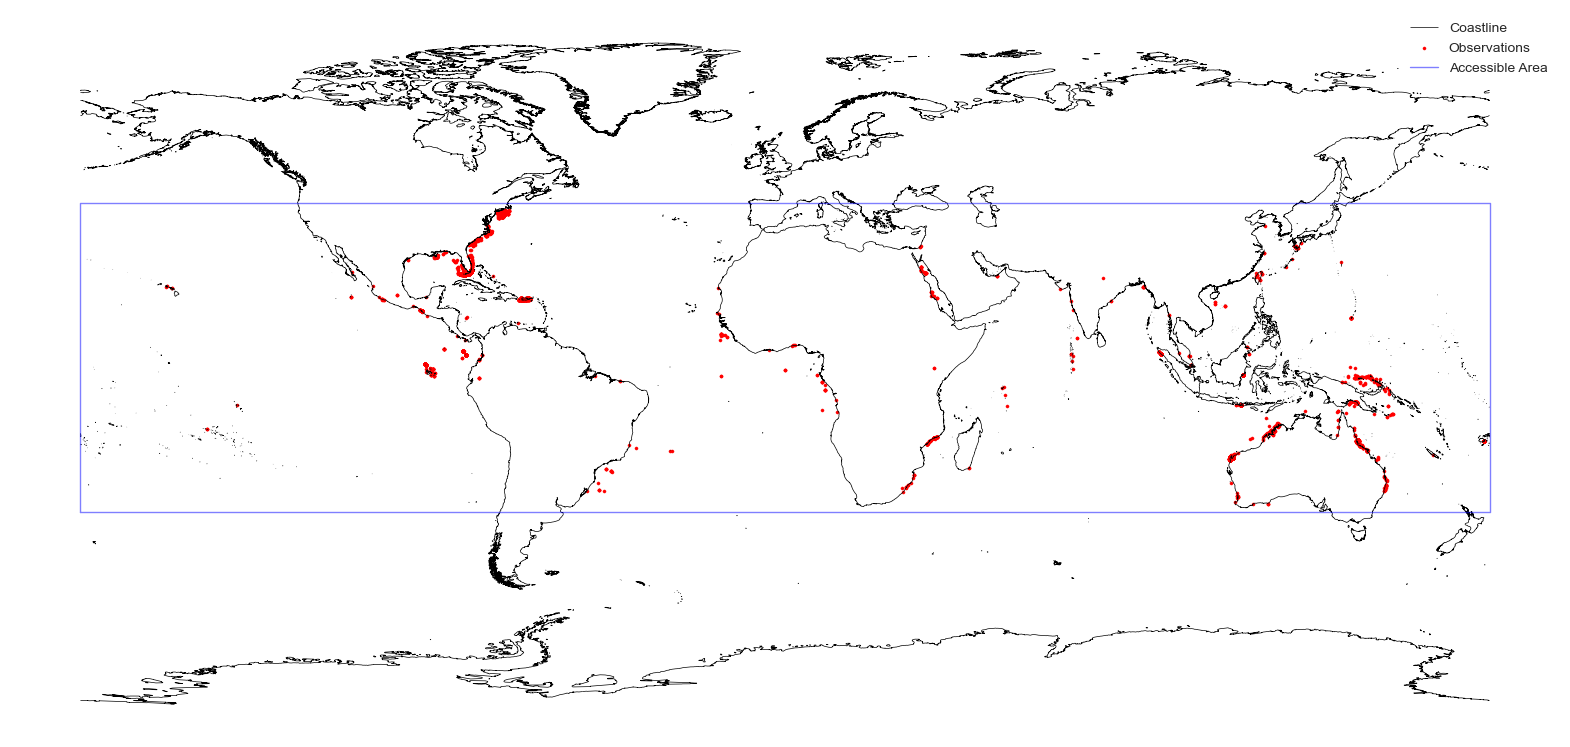

In [34]:
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"])

### 2. Accessible Area Creation
Using the map and also [this source](https://www.fishbase.se/summary/912) we filter to the following accessible area to begin with:
- No land
- Latitude -39 to 46
- Longitude -180 to 180
- If we want to be more specific, we can filter to the distribution areas found in the fishbase source above.
- Another consideration: Depth 0 to 1043m - typically 0-25m. However, we can't filter the area based on bathymetry because the shark isn't only at the bottom, it can be anywhere on the depth axis.

We will use this to:
- Filter presence data to be within this area only
- Sample appropriate background data

In [9]:
MIN_LAT = -39
MAX_LAT = 46

In [10]:
def create_accessible_area(ref_coordinate_space_dataset_path="../data/environmental/bio_oracle/bathymetry.nc"):
    """
    Criteria:
    - -39 to 46 longitude
    - No land
    """
    ds = xr.open_dataset(ref_coordinate_space_dataset_path)
    bathy = ds["bathymetry_mean"]

    lons = bathy["longitude"].values
    lats = bathy["latitude"].values
    lon2d, lat2d = np.meshgrid(lons, lats)
    region_mask = (
        (lat2d >= MIN_LAT) & (lat2d <= MAX_LAT)
    )

    ocean_mask = np.isfinite(bathy.values)[0]
    accessible_area_mask = ocean_mask & region_mask

    accessible_area = xr.DataArray(
        accessible_area_mask.astype(np.uint8),
        coords={"latitude": bathy["latitude"], "longitude": bathy["longitude"]},
        dims=("latitude", "longitude"),
        name="M_accessible"
    )
    return accessible_area_mask, accessible_area

In [ ]:
accessible_area_mask, accessible_area = create_accessible_area()
lons = accessible_area["longitude"].values
lats = accessible_area["latitude"].values
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"], accessible_area=accessible_area,
                      plot_bounding_box=False, limit_to_bounding_box=True)

In [11]:
accessible_area_mask, accessible_area = create_accessible_area()
lons = accessible_area["longitude"].values
lats = accessible_area["latitude"].values

In [ ]:
lons_2d, lats_2d = np.meshgrid(lons, lats)
# These will be needed for predicting later
np.save("../data/predictions/accessible_area_lons.npy", lons_2d)
np.save("../data/predictions/accessible_area_lats.npy", lats_2d)

### 3. Filter Presence Data
- Ensure it is within the accessible area only. This will remove those on land or outside the known latitudinal range.
- TODO: seems like way more is removed than I expected. One of three things:
  - The lack of granularity in bathymetry dataset coordinates is linking many close-to-shore observations as on-shore 
  - People have classed their observations as shore-based instead of sea-based, but only just
  - There are undefined bathymetry values in the sea, i.e. I can't assume undefined <-> on land

In [39]:
def filter_data_to_be_within_accessible_area(gdf):
    gdf = gdf.to_crs(epsg=4326)
    gdf_filtered = gdf[
        gdf.geometry.apply(lambda point: accessible_area.sel(longitude=point.x, latitude=point.y, method="nearest").values == 1)
    ].reset_index(drop=True)
    gdf_removed = gdf[~gdf.index.isin(gdf_filtered.index)].reset_index(drop=True)
    n_removed = gdf.shape[0] - gdf_filtered.shape[0]
    print(f"Filtered out {n_removed} rows based on accessible area, leaving {gdf_filtered.shape[0]} rows")
    return gdf_filtered, gdf_removed

In [ ]:
presence_gdf_filtered, presence_gdf_removed = filter_data_to_be_within_accessible_area(presence_gdf)

# Plotting removed points also to see if I didn't capture some important areas/variables
visualise_data_on_map(coastline, [presence_gdf_filtered, presence_gdf_removed], ["red", "green"], ["Observations", "Removed Observations"],
                      accessible_area=accessible_area, plot_bounding_box=False, limit_to_bounding_box=True)

Filtered out 1662 rows based on accessible area, leaving 16414 rows


### 4. Load Background Data
- Using [this dataset](https://www.gbif.org/occurrence/download?taxon_key=121) which consists of all Elasmobranchii (this includes sharks, rays, some fishes)
- For each month and year, build a sampling effort surface to sample points based on probabilities.
  - Note that those close to presence points are removed so it helps to generate more true absence points
- This helps us in two ways:
  - It helps tackle sampling bias by showcasing where people usually go to spot similar animals
  - It helps to define more likely true absence points -> places where people go often and spot similar animals, but never ever spot a scalloped hammerhead, are more likely to be absence rather than random data points

In [42]:
background_df = load_raw_presence_data('../data/gbif/background_data.csv')
background_df = filter_basic_issues_from_dataset(background_df)
background_gdf = gpd.GeoDataFrame(
    background_df,
    geometry=gpd.points_from_xy(background_df.longitude, background_df.latitude),
    crs="EPSG:4326"
)
background_df, _ = filter_data_to_be_within_accessible_area(background_gdf)

Species Counts: 2663
Initial number of rows: 5041602
Filtered out 1272188 rows based on coordinate uncertainty, leaving 3769414 rows
Filtered out 1940107 rows based on missing coordinate uncertainty, leaving 1829307 rows
Filtered out 4747 rows based on missing lat/lon, leaving 1824560 rows
Filtered out 23046 rows based on invalid dates, leaving 1801514 rows
Filtered out 237792 rows based on being too old, leaving 1563722 rows
Filtered out 534563 rows based on accessible area, leaving 1029159 rows


In [ ]:
def filter_dataset_1_by_distance_to_dataset_2(gdf_1, gdf_2, threshold_m):
    gdf_1 = gdf_1.to_crs(epsg=3857)
    gdf_2 = gdf_2.to_crs(epsg=3857)
    joined = gdf_1.sjoin_nearest(gdf_2[["geometry"]], how="left", distance_col="dist_m")
    joined = joined.drop_duplicates("gbifID")
    gdf_1 = gdf_1.loc[joined["dist_m"] >= threshold_m].copy()
    return gdf_1


def create_raw_raster(gdf, accessible_area):
    raster = np.zeros_like(accessible_area, dtype=int)
    lons = accessible_area["longitude"].values
    lats = accessible_area["latitude"].values
    for lon, lat in zip(gdf["longitude"], gdf["latitude"]):
        lon_idx = np.abs(lons - lon).argmin()
        lat_idx = np.abs(lats - lat).argmin()
        if accessible_area.sel(longitude=lon, latitude=lat, method="nearest").values == 0:
            continue
        raster[lat_idx, lon_idx] += 1
    return raster


def create_probability_raster(raw_raster, sigma=1):
    prob_raster = gaussian_filter(raw_raster.astype(float), sigma=sigma)
    prob_raster /= prob_raster.sum()
    return prob_raster

In [ ]:
background_rasters = {}
for year in tqdm(range(2003, 2024)):
    for month in range(1, 13):
        year_month_gdf = background_gdf[(background_gdf["date"].dt.year == year) & (background_gdf["date"].dt.month == month)]
        year_month_presence = presence_gdf_filtered[(presence_gdf_filtered["date"].dt.year == year) & (presence_gdf_filtered["date"].dt.month == month)]
        year_month_gdf = filter_dataset_1_by_distance_to_dataset_2(year_month_gdf, year_month_presence, 5000)
        raw_raster = create_raw_raster(year_month_gdf, accessible_area)
        prob_raster = create_probability_raster(raw_raster, sigma=1)
        background_rasters[(year, month)] = prob_raster

100%|██████████| 21/21 [06:28<00:00, 18.48s/it]


### 5. Spatial Thinning
- Thin out points close together to further remove sampling effort bias
- Try thinning out so observations fall across fewer unique days. This will help with environmental variable downloads, which take a long time to download at daily cadence.

- TODO: think of a better way to calculate distance metric to account for earth curvature. Good enough for now but the filtering is too harsh due to distance stretching.
- TODO 2: Maybe only spatially thin on a monthly basis instead of not taking temporal info into account. Need to think on the bias implications here - safer for now to stick to full spatial thinning.

In [45]:
def spatially_thin(gdf, min_distance_m):
    '''
    Spatially thin a dataset so that no points are within min_distance_m of each other.
    Reduces sampling bias for the 'presence' data.
    '''
    gdf = gdf.to_crs(epsg=3857)
    coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
    
    tree = cKDTree(coords)
    to_keep = np.ones(len(gdf), dtype=bool)
    for i in range(len(coords)):
        if to_keep[i]:
            neighbors = tree.query_ball_point(coords[i], r=min_distance_m)
            neighbors.remove(i)
            to_keep[neighbors] = False
    return gdf[to_keep].reset_index(drop=True)

presence_gdf_filtered = spatially_thin(presence_gdf_filtered, 1000).reset_index(drop=True)
print(f"Rows: {presence_gdf_filtered.shape[0]}")

Rows: 1982


### 6. Pick Background Points
- For every presence data point with associated time t, sample k background points for the relevant sampling effort surface map for that year/month.
- Doing multiple weak absence points here rather than just 1 because none of the points are as strong as presence. This will also be taken into account during evaluation, where absence points are weighted as more weak evidence.

In [46]:
BG_SIZE_PER_PRESENCE_SAMPLE = 10

1982it [18:02,  1.83it/s] 


Total background points sampled: 18580


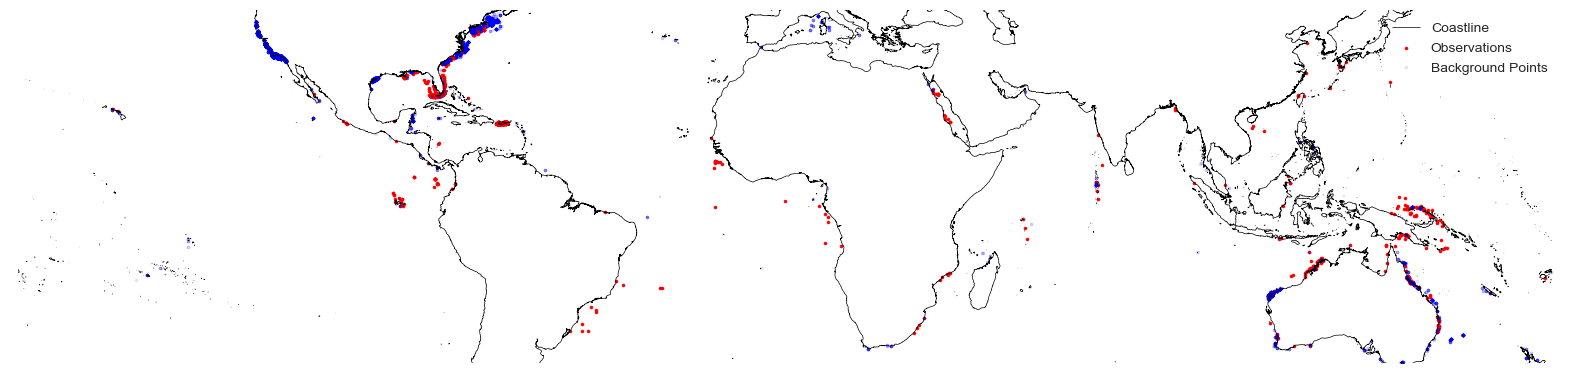

In [47]:
all_background_points = []
background_dates = []
for _, row in tqdm(presence_gdf_filtered.iterrows()):
    year = row["date"].year
    month = row["date"].month
    bg_prob_raster = background_rasters.get((year, month), None)
    if bg_prob_raster is None:
        continue
    
    np.random.seed(42)
    background_points = np.random.choice(
        np.arange(bg_prob_raster.size),
        size=BG_SIZE_PER_PRESENCE_SAMPLE,
        replace=True,
        p=bg_prob_raster.flatten(),
    )
    all_background_points.extend(background_points)
    background_dates.extend([row["date"]] * BG_SIZE_PER_PRESENCE_SAMPLE)
all_background_points = np.array(all_background_points)
print(f"Total background points sampled: {all_background_points.shape[0]}")

background_indices = np.unravel_index(all_background_points, bg_prob_raster.shape)
background_lons = lons[background_indices[1]]
background_lats = lats[background_indices[0]]

visualise_data_on_map(coastline, [presence_gdf_filtered], ["red"], ["Observations"],
                      plot_bounding_box=False, limit_to_bounding_box=True, show_plot=False)
plt.scatter(background_lons, background_lats, color='blue', s=5, alpha=0.1, label="Background Points")
plt.legend()
plt.show()

In [48]:
background_df_filtered = pd.DataFrame({"date": background_dates, "latitude": background_lats, "longitude": background_lons})
background_gdf_filtered = gpd.GeoDataFrame(
    background_df_filtered,
    geometry=gpd.points_from_xy(background_df_filtered.longitude, background_df_filtered.latitude),
    crs="EPSG:4326",
)

In [ ]:
presence_gdf_filtered.to_file("../data/processed/presence_data_filtered.geojson", driver="GeoJSON")
background_gdf_filtered.to_file("../data/processed/background_data_filtered.geojson", driver="GeoJSON")

### 7. Load Environmental Data

- First, take a 10 year range. This is simply due to query number limitations in Meteomatics. With more time, take the full data!
- Also, the Meteomatics data is taken at 1 degree resolution. This is quite coarse, which is especially troublesome at near-coastal observations which often end up being absorbed by the coast instead of the sea rendering them undefined. In future, with more time, take much higher resolution if we can continue to use the Meteomatics API.
- Each data point in both presence and absence data is mapped to the closest lat/lon for each env variable.

- VARIABLES:
  - Fixed - NASA:
    - Distance to Shore
  - Dynamic (retrieving at a daily level) - Meteomatics:
    - Bathymetry
    - Sea Surface Temperature
    - Ocean Current Speed - only available from 2015 onwards

  - In future:
    - Ocean Current Direction [NASA OSCAR]
    - Ocean Current Vectors [NASA OSCAR]
    - Salinity [NASA SSS]
    - Chlorophyll-a [NASA MODIS]
    - Sea Surface Height [NASA SWOT]
      - Winds [NASA CCMP L4]

  - Note that some of the above 'future' variables were not chosen due to their very limited overlap date-wise with the presence/absence dataset dates

In [142]:
presence_gdf_filtered = presence_gdf_filtered[presence_gdf_filtered["date"] >= pd.Timestamp("2010-01-01")].reset_index(drop=True)
presence_gdf_filtered = presence_gdf_filtered[presence_gdf_filtered["date"] <= pd.Timestamp("2019-12-31")].reset_index(drop=True)
presence_gdf_filtered["month-year"] = presence_gdf_filtered["date"].dt.to_period("M")
len(presence_gdf_filtered)

1481

In [176]:
background_gdf_filtered = background_gdf_filtered[background_gdf_filtered["date"] >= pd.Timestamp("2010-01-01")].reset_index(drop=True)
background_gdf_filtered = background_gdf_filtered[background_gdf_filtered["date"] <= pd.Timestamp("2019-12-31")].reset_index(drop=True)
background_gdf_filtered["month-year"] = background_gdf_filtered["date"].dt.to_period("M")
len(background_gdf_filtered)

14810

In [ ]:
def get_meteomatics_data_in_bulk(year, month, parameter,
                                 lat_min, lat_max, lon_min, lon_max,
                                 res_deg=1.0, interval="PT24H", fmt="csv"):
    """
    Download Meteomatics data for a given month over a latitude/longitude bounding box.
    """
    base_url = "https://api.meteomatics.com"
    days_in_month = calendar.monthrange(year, month)[1]
    start_iso = f"{year}-{month:02d}-01T00:00:00Z"
    end_iso = f"{year}-{month:02d}-{days_in_month}T23:00:00Z"
    date_range = f"{start_iso}--{end_iso}:{interval}"
    
    bbox = f"{lat_max},{lon_min}_{lat_min},{lon_max}:{res_deg},{res_deg}"
    url = f"{base_url}/{date_range}/{parameter}/{bbox}/{fmt}"

    response = requests.get(url, auth=HTTPBasicAuth(USERNAME, PASSWORD))

    if response.status_code != 200:
        print(f"Error fetching data ({response.status_code}): {response.text[:200]}")
        return None

    df = pd.read_csv(StringIO(response.text), sep=";")
    return df

In [ ]:
def get_variable_for_all_time(var_name, save_name):
    for month_year in tqdm(presence_gdf_filtered["month-year"].unique()):
        year = month_year.year
        month = month_year.month
        
        # No data available for ocean currents before 2015
        if "current" in var_name and year < 2015:
            continue
        df = get_meteomatics_data_in_bulk(
            year,
            month,
            var_name,
            lat_min=-39,
            lat_max=46,
            lon_min=-180,
            lon_max=180,
            res_deg=1.0,
            interval="PT24H",
        )
        if df is not None:
            df.to_csv(f"../data/environmental/meteomatics/{save_name}/{year}_{month:02d}.csv", index=False)

def merge_variable_into_gdfs(var_name, save_name, presence_gdf_filtered, background_gdf_filtered):
    
    for col in ["index_right", "lon", "lat", "value"]:
        if col in presence_gdf_filtered.columns:
            presence_gdf_filtered.drop(columns=[col], inplace=True)
        if col in background_gdf_filtered.columns:
            background_gdf_filtered.drop(columns=[col], inplace=True)
        
    presence_gdf_filtered = presence_gdf_filtered.to_crs(epsg=4326)
    background_gdf_filtered = background_gdf_filtered.to_crs(epsg=4326)
    for month_year in tqdm(presence_gdf_filtered["month-year"].unique()):
        if "current" in var_name and month_year.year < 2015:
            continue
        year = month_year.year
        month = month_year.month
        df = pd.read_csv(f"../data/environmental/meteomatics/{save_name}/{year}_{month:02d}.csv")
        df["validdate"] = pd.to_datetime(df["validdate"])

        subset_gdf = presence_gdf_filtered[
            (presence_gdf_filtered["date"].dt.year == year)
            & (presence_gdf_filtered["date"].dt.month == month)
        ]

        for date in subset_gdf["date"].dt.date.unique():
            presence_gdf_filtered.loc[
                (presence_gdf_filtered["date"].dt.year == year)
                & (presence_gdf_filtered["date"].dt.month == month)
                & (presence_gdf_filtered["date"].dt.date == date),
                save_name
            ] = np.nan
            background_gdf_filtered.loc[
                (background_gdf_filtered["date"].dt.year == year)
                & (background_gdf_filtered["date"].dt.month == month)
                & (background_gdf_filtered["date"].dt.date == date),
                save_name,
            ] = np.nan

            time_gf = df[df["validdate"].dt.date == date]
            gdf = gpd.GeoDataFrame(
                time_gf,
                geometry=gpd.points_from_xy(time_gf.lon, time_gf.lat),
                crs="EPSG:4326",
            )
            # do sjoin_nearest
            joined = gpd.sjoin_nearest(
                subset_gdf[
                    (subset_gdf["date"].dt.year == year)
                    & (subset_gdf["date"].dt.month == month)
                    & (subset_gdf["date"].dt.date == date)
                ],
                gdf,
                how="left",
                distance_col="dist",
            )
            presence_gdf_filtered.loc[
                (presence_gdf_filtered["date"].dt.year == year)
                & (presence_gdf_filtered["date"].dt.month == month)
                & (presence_gdf_filtered["date"].dt.date == date),
                save_name
            ] = joined[var_name].values

            joined = gpd.sjoin_nearest(
                background_gdf_filtered[
                    (background_gdf_filtered["date"].dt.year == year)
                    & (background_gdf_filtered["date"].dt.month == month)
                    & (background_gdf_filtered["date"].dt.date == date)
                ],
                gdf,
                how="left",
                distance_col="dist",
            )
            background_gdf_filtered.loc[
                (background_gdf_filtered["date"].dt.year == year)
                & (background_gdf_filtered["date"].dt.month == month)
                & (background_gdf_filtered["date"].dt.date == date),
                save_name,
            ] = joined[var_name].values
    return presence_gdf_filtered, background_gdf_filtered

In [ ]:
for var_name, save_name in [
    ("t_sea_sfc:C", "sst"),
    ("ocean_depth:m", "ocean_depth"),
    ("ocean_current_speed:ms", "current_speed"),
    ("ocean_current_direction:ms", "current_direction"),
]:
    get_variable_for_all_time(var_name, save_name)
    presence_gdf_filtered, background_gdf_filtered = merge_variable_into_gdfs(
        var_name,
        save_name,
        presence_gdf_filtered,
        background_gdf_filtered,
    )

100%|██████████| 82/82 [00:37<00:00,  2.20it/s]


In [ ]:
# Get distance to coast, which is a little different to above as it's direct from NASA rather 
# than through Meteomatics
with open('../data/environmental/nasa/dist2coast.txt', 'r') as f:
    dist2coast = f.readlines()
dist2coast = pd.read_csv(
    StringIO("".join(dist2coast)), sep="\t", header=None, names=["lon", "lat", "value"]
)
dist2coast["value"] = dist2coast["value"] * 1000  # convert to metres
dist2coast_gdf = gpd.GeoDataFrame(
    dist2coast,
    geometry=gpd.points_from_xy(dist2coast.lon, dist2coast.lat),
    crs="EPSG:4326"
)

presence_gdf_filtered = presence_gdf_filtered.to_crs(epsg=4326)
presence_gdf_filtered = presence_gdf_filtered.sjoin_nearest(dist2coast_gdf, how="left")
background_gdf_filtered = background_gdf_filtered.to_crs(epsg=4326)
background_gdf_filtered = background_gdf_filtered.sjoin_nearest(
    dist2coast_gdf, how="left"
)
background_gdf_filtered["distance_to_shore_m"] = background_gdf_filtered["value"]
presence_gdf_filtered["distance_to_shore_m"] = presence_gdf_filtered["value"]

In [ ]:
# Some points are mapped to land areas due to low resolution. Set to NaN - XGBoost will handle this.
presence_gdf_filtered["sst"] = presence_gdf_filtered["sst"].apply(
    lambda x: np.nan if (x <= -50) else x
)
background_gdf_filtered["sst"] = background_gdf_filtered["sst"].apply(
    lambda x: np.nan if (x <= -50) else x
)

presence_gdf_filtered["ocean_depth"] = presence_gdf_filtered["ocean_depth"].apply(
    lambda x: np.nan if (x < 0) else x
)
background_gdf_filtered["ocean_depth"] = background_gdf_filtered["ocean_depth"].apply(
    lambda x: np.nan if (x < 0) else x
)

presence_gdf_filtered["current_speed"] = presence_gdf_filtered["current_speed"].apply(
    lambda x: np.nan if (x < 0) else x
)
background_gdf_filtered["current_speed"] = background_gdf_filtered[
    "current_speed"
].apply(lambda x: np.nan if (x < 0) else x)

presence_gdf_filtered = presence_gdf_filtered.reset_index(drop=True)
background_gdf_filtered = background_gdf_filtered.reset_index(drop=True)

len(presence_gdf_filtered), len(background_gdf_filtered)

(1043, 7565)

### 8. Feature Viz
- Quick check of if there look to be correlations
  - Sea surface temperature massively stands out!
  - Current speed also pretty correlated - sharks like it fast!

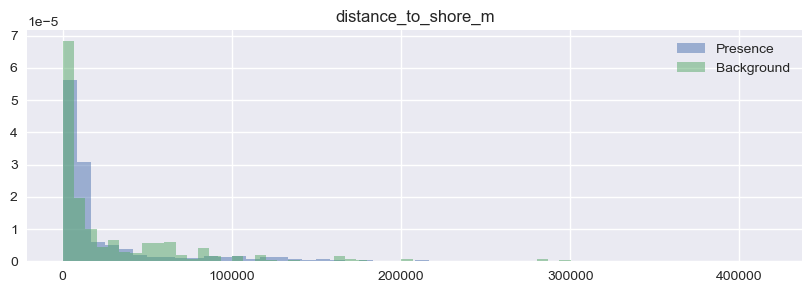

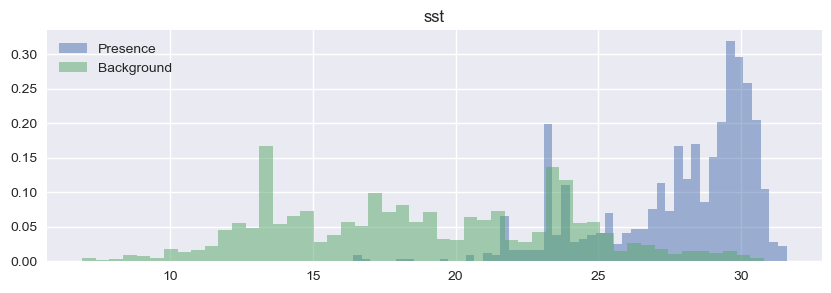

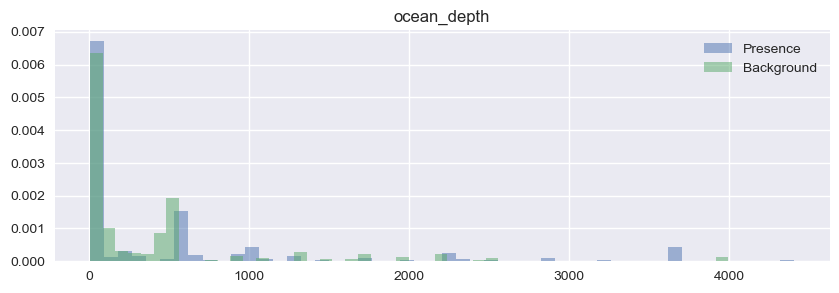

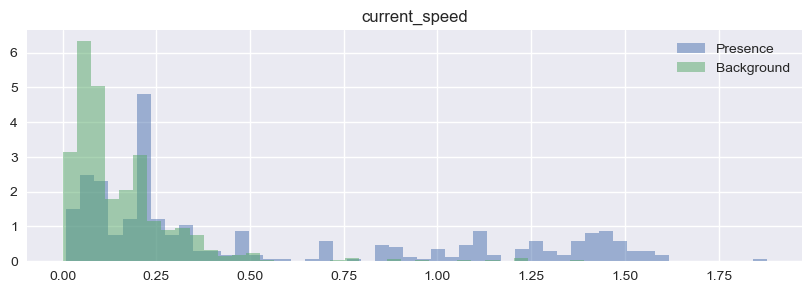

In [ ]:
# Check out histograms of variables
PREDICTOR_COLS = [
    "distance_to_shore_m",
    "sst",
    "ocean_depth",
    "current_speed"
]

for predictor in PREDICTOR_COLS:
    plt.figure(figsize=(10, 3))
    plt.hist(presence_gdf_filtered[predictor], bins=50, alpha=0.5, label="Presence", density=True)
    plt.hist(background_gdf_filtered[predictor], bins=50, alpha=0.5, label="Background", density=True)
    plt.title(predictor)
    plt.legend()
    plt.show()

### 9. Modelling with Spatial Cross Validation
- Create spatial folds for all points
- Fit XGBoost model across all folds
- Basic threshold optimisation - use small validation set to find optimal threshold, then evaluate using that on the left out set
- Obtain precision, recall and f1_score for all folds - to evaluate further in the next section

#### 9.1 Prepare Data and Create Spatial Fold IDs
- Binary classification problem
- The spatial fold IDs are based on points being at least 50km away from each other to ensure there isn't locality bias in evaluation

In [271]:
NUM_FOLDS = 5

In [272]:
def prepare_data_for_modelling(presence_gdf, background_gdf, min_distance_between_folds_m=50000):
    presence_gdf["label"] = 1
    background_gdf["label"] = 0
    presence_gdf = presence_gdf.to_crs(epsg=4326)
    background_gdf = background_gdf.to_crs(epsg=4326)
    full_gdf = pd.concat([presence_gdf, background_gdf], ignore_index=True).reset_index(drop=True)
    X = full_gdf[PREDICTOR_COLS].values
    y = full_gdf["label"].values
    return full_gdf, X, y

def create_spatial_folds(full_gdf, num_folds=3, min_distance_between_folds_m=50000):
    full_gdf = full_gdf.to_crs(epsg=3857)
    coords = np.vstack([full_gdf.geometry.x, full_gdf.geometry.y]).T
    tree = cKDTree(coords)
    fold_ids = -1 * np.ones(len(full_gdf), dtype=int)
    
    current_fold = 0
    for i in range(len(full_gdf)):
        if fold_ids[i] == -1:
            fold_ids[i] = current_fold
            neighbors = tree.query_ball_point(coords[i], r=min_distance_between_folds_m)
            neighbors.remove(i)
            fold_ids[neighbors] = current_fold
            current_fold = (current_fold + 1) % num_folds  # Cycle through - i.e. each fold will be distributed across the map
    full_gdf["fold_id"] = fold_ids
    return full_gdf, full_gdf["fold_id"].values

In [273]:
full_gdf, X, y = prepare_data_for_modelling(presence_gdf_filtered, background_gdf_filtered)
full_gdf, fold_ids = create_spatial_folds(full_gdf, num_folds=NUM_FOLDS)
# Ensure decent representation of points in each fold
full_gdf[full_gdf["label"] == 0]["fold_id"].value_counts().sort_index(), full_gdf[full_gdf["label"] == 1]["fold_id"].value_counts().sort_index()

(fold_id
 0    1118
 1    2405
 2     881
 3    1913
 4    1248
 Name: count, dtype: int64,
 fold_id
 0    272
 1    153
 2    133
 3    321
 4    164
 Name: count, dtype: int64)

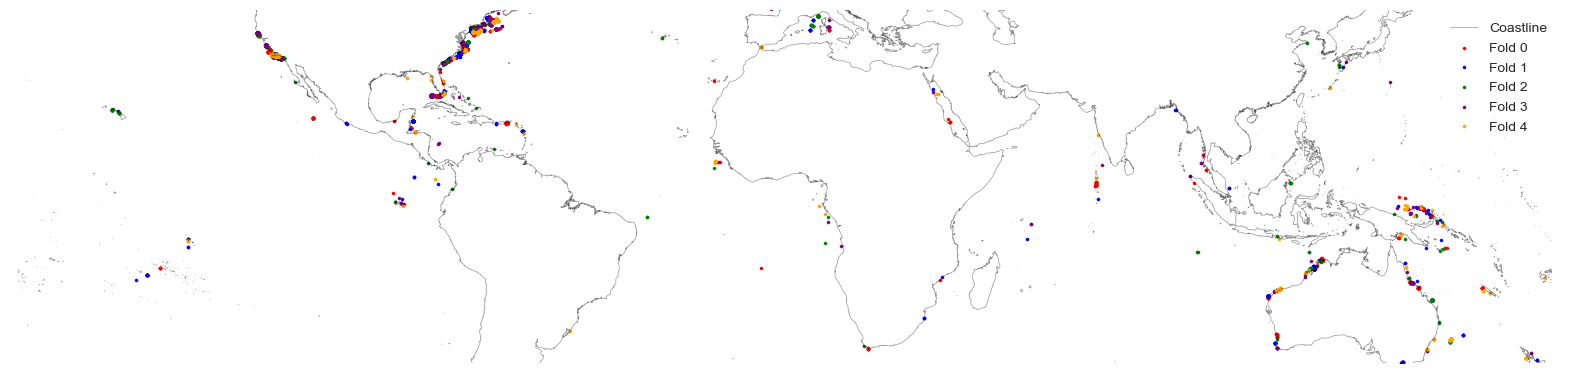

In [274]:
# Visualise folds
full_gdf = full_gdf.to_crs(epsg=4326)
visualise_data_on_map(coastline, 
                      [full_gdf[full_gdf["fold_id"] == i] for i in range(NUM_FOLDS)], 
                      ["red", "blue", "green", "purple", "orange"],
                      [f"Fold {i}" for i in range(NUM_FOLDS)],
                      coastline_alpha=0.4, plot_bounding_box=False, limit_to_bounding_box=True)

#### 9.2 Train and Evaluate XGBoost Model with Spatial CV
- Need lots of regulation due to very small presence data size
- Evaluation is AUCPR due to heavy class imbalance - i.e. we are predicting a rare class
  - Also due to class imbalance I have set weights per class to combat this
- Trying to reduce overfitting via early stopping, max_depth, row + column sampling per tree, L2 norm, L1 norm
- Generalisation typically improves if using a small learning rate with more trees
- n_jobs just there to speed up training

In [ ]:
def split_train_val_test(X, y, fold_ids, test_fold_id):
    fold_mask = (fold_ids == test_fold_id)
    X_test, y_test = X[fold_mask], y[fold_mask]
    X_train_val, y_train_val = X[~fold_mask], y[~fold_mask]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=0, stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


def calculate_class_weights(y_train):
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    positive_weight = n_neg / max(n_pos, 1)
    return positive_weight


def train_xgboost_model(X_train, y_train, X_val, y_val, positive_weight):
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        n_estimators=2000,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.1,
        scale_pos_weight=positive_weight,
        n_jobs=4,
        early_stopping_rounds=50,
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    return model


def find_optimal_threshold(model, X_val, y_val):
    """Use F1 Score weighted by class to find optimal threshold."""
    y_probs = model.predict_proba(X_val)[:, 1]
    weights = np.where(y_val == 1, 0.5 / (y_val == 1).sum(), 0.5 / (y_val == 0).sum())
    precision, recall, thresholds = precision_recall_curve(y_val, y_probs, sample_weight=weights)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
    best_idx = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_idx - 1] if best_idx > 0 else 0.5
    return best_threshold


def evaluate_model(model, X_test, y_test, threshold):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)
    weights = np.where(y_test == 1, 0.5 / (y_test == 1).sum(), 0.5 / (y_test == 0).sum())
    precision = precision_score(y_test, y_pred, sample_weight=weights)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, sample_weight=weights)
    return precision, recall, f1

In [276]:
precisions, recalls, f1_scores, best_thresholds = [], [], [], []
for i in range(NUM_FOLDS):
    X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y, fold_ids, test_fold_id=i)
    pos_weight = calculate_class_weights(y_train)
    xgbm = train_xgboost_model(X_train, y_train, X_val, y_val, pos_weight)
    best_threshold = find_optimal_threshold(xgbm, X_val, y_val)
    precision, recall, f1 = evaluate_model(xgbm, X_test, y_test, best_threshold)
    print("Stopped after {} trees".format(xgbm.best_iteration))

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    best_thresholds.append(best_threshold)

Stopped after 660 trees
Stopped after 983 trees
Stopped after 860 trees
Stopped after 731 trees
Stopped after 1072 trees


In [277]:
for i in range(NUM_FOLDS):
    print(
        f"Fold {i+1}: P={precisions[i]:.3f}, R={recalls[i]:.3f}, F1={f1_scores[i]:.3f} (thr={best_thresholds[i]:.8f})"
    )

Fold 1: P=0.695, R=0.890, F1=0.780 (thr=0.13915898)
Fold 2: P=0.723, R=0.922, F1=0.810 (thr=0.22515009)
Fold 3: P=0.839, R=0.857, F1=0.848 (thr=0.44942743)
Fold 4: P=0.832, R=0.738, F1=0.782 (thr=0.14619941)
Fold 5: P=0.676, R=0.988, F1=0.803 (thr=0.04031609)


### 10. Evaluation, Final Model and Interpretation
- Decent weighted F1 score of 80% and very consistent!
- Model seems consistent enough to suggest it is generalising to some degree. Train a final model on all data possible with a small validation set.
- Checking out feature importances using XGBoost gain - as expected sea surface temperature the most important, but good to see that all variables play a role.
- Partial dependence plot showing how sharks prefer a temperature increase, happen to exist at all bathymetry levels (though they are usually on the surface), can be close or far from shore, and have preference for higher current speeds


In [278]:
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print(f"Mean F1 Score: {mean_f1:.3f} ± {std_f1:.3f}")

Mean F1 Score: 0.805 ± 0.025


In [279]:
X_train, X_val, _, y_train, y_val, _ = split_train_val_test(
    X, y, fold_ids, test_fold_id=1000  # Not a real id, i.e. no test set
)
pos_weight = calculate_class_weights(y_train)
final_model = train_xgboost_model(X_train, y_train, X_val, y_val, pos_weight)
best_threshold = find_optimal_threshold(final_model, X_val, y_val)
print("Final model stopped after {} trees".format(final_model.best_iteration))

Final model stopped after 931 trees


In [280]:
importances = final_model.get_booster().get_score(importance_type="gain")
importance_df = {}
for i, var in enumerate(PREDICTOR_COLS):
    importance_df[var] = importances[f"f{i}"]
importance_df

{'distance_to_shore_m': 6.41435432434082,
 'sst': 26.890413284301758,
 'ocean_depth': 10.471839904785156,
 'current_speed': 8.603719711303711}

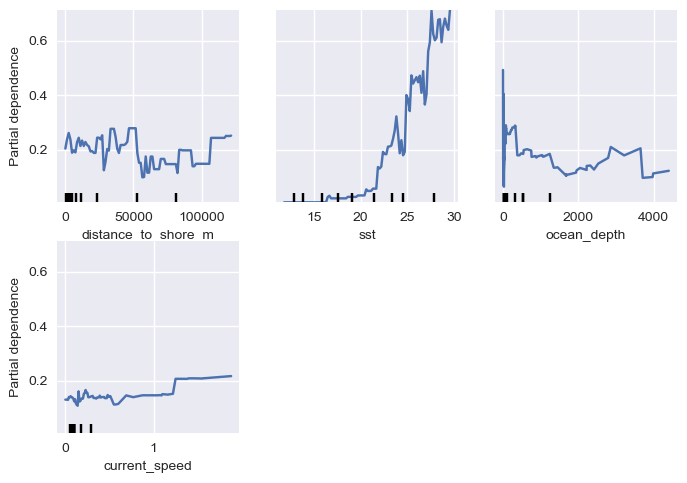

In [347]:
X_val_filled = X_val.copy()
X_val_filled = X_val_filled.astype(float)
for col in range(X_val.shape[1]):
    median_val = np.nanmedian(X_val[:, col])
    X_val_filled[np.isnan(X_val_filled[:, col]), col] = median_val

PartialDependenceDisplay.from_estimator(
    final_model,
    X_val_filled,
    features=[i for i in range(len(PREDICTOR_COLS))],
    feature_names=PREDICTOR_COLS,
    kind="average",
)
plt.show()

### 11. Visualisation
- Download the data for the most recent environmental variables of today to get the final plot
- Get the data for the accessible area
- Map out the probability distribution in the accessible area for today! Where are the sharks likely to be right now, as of October 3rd 2025?
- Super interesting to see the wave surface temperature and directly correlated ocean current in the mid-west of the map!

In [ ]:
today_date = pd.Timestamp("2025-10-03")
for var_name, save_name in [("t_sea_sfc:C", "sst"), ("ocean_depth:m", "ocean_depth"), ("ocean_current_speed:ms", "current_speed")]:
    df = get_meteomatics_data_in_bulk(
        2025,
        10,
        var_name,
        -39,
        46,
        -180,
        180,
    )
    df["validdate"] = pd.to_datetime(df["validdate"])
    df = df[df["validdate"].dt.date == today_date.date()].reset_index(drop=True)
    print(len(df))
    if df is not None:
        df.to_csv(f"../data/environmental/meteomatics/today/{save_name}_{today_date.strftime('%Y_%m_%d')}.csv", index=False)

31046
31046
31046


In [ ]:
ii, jj = np.where(accessible_area_mask.astype(bool))
lat_arr = lats[ii]
lon_arr = lons[jj]

accessible_df = pd.DataFrame({"latitude": lat_arr, "longitude": lon_arr})
accessible_gdf = gpd.GeoDataFrame(
    accessible_df,
    geometry=gpd.points_from_xy(accessible_df.longitude, accessible_df.latitude),
    crs="EPSG:4326",
)

sst_df = pd.read_csv(f"../data/environmental/meteomatics/today/sst_{today_date.strftime('%Y_%m_%d')}.csv")
sst_df["validdate"] = pd.to_datetime(sst_df["validdate"])
sst_gdf = gpd.GeoDataFrame(
    sst_df,
    geometry=gpd.points_from_xy(sst_df.lon, sst_df.lat),
    crs="EPSG:4326",
)
accessible_gdf = gpd.sjoin_nearest(accessible_gdf, sst_gdf, how="left")
accessible_gdf["sst"] = accessible_gdf["t_sea_sfc:C"]
accessible_gdf.drop(columns=["index_right", "lon", "lat", "t_sea_sfc:C", "validdate"], inplace=True)

ocean_depth_df = pd.read_csv(f"../data/environmental/meteomatics/today/ocean_depth_{today_date.strftime('%Y_%m_%d')}.csv")
ocean_depth_df["validdate"] = pd.to_datetime(ocean_depth_df["validdate"])
ocean_depth_gdf = gpd.GeoDataFrame(
    ocean_depth_df,
    geometry=gpd.points_from_xy(ocean_depth_df.lon, ocean_depth_df.lat),
    crs="EPSG:4326",
)
accessible_gdf = gpd.sjoin_nearest(accessible_gdf, ocean_depth_gdf, how="left")
accessible_gdf["ocean_depth"] = accessible_gdf["ocean_depth:m"]
accessible_gdf.drop(columns=["index_right", "lon", "lat", "ocean_depth:m", "validdate"], inplace=True)

current_speed_df = pd.read_csv(f"../data/environmental/meteomatics/today/current_speed_{today_date.strftime('%Y_%m_%d')}.csv")
current_speed_df["validdate"] = pd.to_datetime(current_speed_df["validdate"])
current_speed_gdf = gpd.GeoDataFrame(
    current_speed_df,
    geometry=gpd.points_from_xy(current_speed_df.lon, current_speed_df.lat),
    crs="EPSG:4326",
)
accessible_gdf = gpd.sjoin_nearest(accessible_gdf, current_speed_gdf, how="left")
accessible_gdf["current_speed"] = accessible_gdf["ocean_current_speed:ms"]
accessible_gdf.drop(columns=["index_right", "lon", "lat", "ocean_current_speed:ms", "validdate"], inplace=True)
accessible_gdf = accessible_gdf.sjoin_nearest(dist2coast_gdf, how="left")
accessible_gdf["distance_to_shore_m"] = accessible_gdf["value"]

In [320]:
accessible_gdf["sst"] = accessible_gdf["sst"].apply(
    lambda x: np.nan if (x <= -50) else x
)
accessible_gdf["ocean_depth"] = accessible_gdf["ocean_depth"].apply(
    lambda x: np.nan if (x < 0) else x
)
accessible_gdf["current_speed"] = accessible_gdf["current_speed"].apply(
    lambda x: np.nan if (x < 0) else x
)

In [ ]:
# plot the input variables on a map
for predictor in PREDICTOR_COLS:
    plt.figure(figsize=(10, 5))
    sc = plt.scatter(
        accessible_gdf["longitude"],
        accessible_gdf["latitude"],
        c=accessible_gdf[predictor],
        s=5,
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(sc, label=predictor)
    plt.title(f"{predictor} on {today_date.strftime('%Y-%m-%d')}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(-180, 180)
    plt.ylim(MIN_LAT, MAX_LAT)
    plt.show()

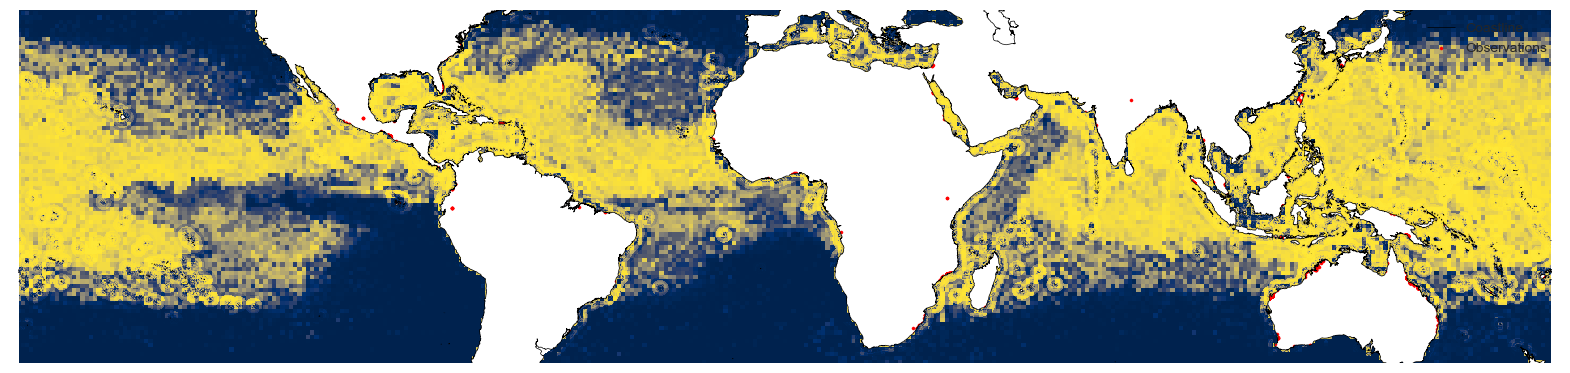

In [ ]:
X = accessible_gdf[PREDICTOR_COLS].values
accessible_gdf["presence_probability"] = final_model.predict_proba(X)[:, 1]
accessible_gdf["predicted_label"] = (accessible_gdf["presence_probability"] >= best_threshold).astype(int)

predictions = np.zeros_like(accessible_area_mask, dtype=float) * np.nan
for lon, lat, prob in zip(accessible_gdf["longitude"], accessible_gdf["latitude"], accessible_gdf["presence_probability"]):
    lon_idx = np.abs(lons - lon).argmin()
    lat_idx = np.abs(lats - lat).argmin()
    predictions[lat_idx, lon_idx] = prob

visualise_data_on_map(
    coastline,
    [presence_gdf],
    ["red"],
    ["Observations"],
    plot_bounding_box=False,
    limit_to_bounding_box=True,
    show_plot=False,
)
mesh = plt.gca().pcolormesh(
    lons, lats, predictions, cmap="cividis", label="Predicted Suitability"
)
plt.legend()
plt.show()

In [ ]:
np.save(f"../data/predictions/predictions_{today_date.strftime('%Y_%m_%d')}.npy", predictions)
final_model.save_model("../models/scalloped_hammerhead_xgb_model.json")